# Linear Spectral Unmixing with Least Squares

## Problem Statement

In the case of spectral data, for a given pixel we suppose to have a set of intensity measurements at different wavelengths, e.g., $I = [I(\lambda_1),I(\lambda_2),\dots,I(\lambda_n)]$, with $n=32$ for instance. For each one of these spectral bands $\lambda_i$, with $i=1,\dots,n$, and for each fluorophore $f$, with $f=1,\dots,m$, we assume to know the reference spectra $R_f=[R_f(\lambda_1), R_f(\lambda_2), \dots, R_f(\lambda_n)]$. Therefore, $I $ is a column vector of size $n$ and $R_f$ are columns of a matrix $\mathbf{R}$ of size $m\times n$. In this context, we define the concentration of the different fluorophores in the sample as a row vector $C = [C_1, C_2, \dots, C_m]$ of size $m$. Therefore, the problem of linear unmixing reads as follows: <br><br>

\begin{equation}
I = C\mathbf{R}
\end{equation}

or, by specifying the vectors and matrix:

\begin{align}
    \begin{bmatrix}
        I(\lambda_1) \\
        I(\lambda_2) \\
        \vdots \\
        I(\lambda_n)
    \end{bmatrix}
        = 
    \begin{bmatrix}
        C_{1} & C_{2} & \dots & C_{m}
    \end{bmatrix}
    \begin{bmatrix}
        R_{1}(\lambda_1) & R_{1}(\lambda_2) & \dots & R_{1}(\lambda_n) \\
        R_{2}(\lambda_1) & R_{2}(\lambda_2) & \dots & R_{2}(\lambda_n) \\
        \vdots & \vdots & \ddots & \vdots \\
        R_{m}(\lambda_1) & R_{m}(\lambda_2) & \dots & R_{m}(\lambda_n) \\
    \end{bmatrix}
\end{align}

## Least Square Estimation

Least Squares is a method that allows to solve the system. It works as follows:

**Goal:** to compute $C$ such that it minimizes the objective $J(C)=||I - C\mathbf{R}||^2$.

**How:** by setting the derivative of $J(C)$ w.r.t. $C$ to $0$. Namely:
\begin{align}
\frac{\partial{J(C)}}{\partial{C}}=-2(I-C\mathbf{R})\mathbf{R}^T=0 \Longrightarrow C\mathbf{R}\mathbf{R}^T=I\mathbf{R}^T \Longrightarrow C=I\mathbf{R}^T(\mathbf{R}\mathbf{R}^T)^{-1} 
\end{align}

**NOTES**

- Notice that in the context of a spectral image we need to repeat this procedure for every pixel.
- $I(\lambda_i)$'s are the intensity values for a given pixel in the mixed image at wavelength $\lambda_i$.
- $R_f(\lambda_i)$'s are the intensity values in the reference spectrum of fluorophore $f$ at wavelength $\lambda_i$.
- For the moment we work with MIP and not with the whole 3D volumes. 

### 1. Data Preparation

Load mixed image & metadata:

In [32]:
import os
import json
import tifffile as tiff

DATA_DIR = '/group/jug/federico/microsim/sim_spectral_data/240712_v4'
load_mip = False

mixed_opt_img = tiff.imread(
    os.path.join(
        DATA_DIR, 
        f"{"mips" if load_mip else "imgs"}/optical_mixed{"_mip" if load_mip else ""}.tif"
    )
)
print("Loaded optical mixed image!")

Loaded optical mixed image!


In [33]:
mixed_digital_img = tiff.imread(
    os.path.join(
        DATA_DIR, 
        f"{"mips" if load_mip else "imgs"}/digital_mixed{"_mip" if load_mip else ""}.tif"
    )
)
print("Loaded digital mixed image!")

Loaded digital mixed image!


In [34]:
with open(os.path.join(DATA_DIR, "sim_coords.json"), "r") as f:
    coords_metadata = json.load(f)

try:    
    with open(os.path.join(DATA_DIR, "sim_metadata.json"), "r") as f:
        sim_metadata = json.load(f)
except FileNotFoundError as e:
    print("Metadata file not found!")
    sim_metadata = None

In [35]:
mixed_opt_img.shape, mixed_digital_img.shape, coords_metadata.keys(), sim_metadata.keys()

((32, 52, 512, 512),
 (32, 13, 128, 128),
 dict_keys(['x_coords', 'y_coords', 'z_coords', 'w_bins']),
 dict_keys(['fluorophores', 'light_powers', 'downscale', 'detect_exposure_ms', 'detect_quantum_eff', 'min_max_wavelength']))

In [36]:
for k, v in sim_metadata.items():
    print(f"{k}: {v}")

fluorophores: ['mTurquoise', 'EGFP', 'EYFP']
light_powers: [3.0, 1.0, 1.0]
downscale: 4
detect_exposure_ms: 25
detect_quantum_eff: 0.82
min_max_wavelength: [460, 550]


Get reference spectra from `FPBase` using `microsim` API:

In [37]:
from microsim.schema.sample import Fluorophore

def fetch_FPs(fp_names: list[str]) -> list[Fluorophore]:
    return [Fluorophore.from_fpbase(name=fp_name) for fp_name in fp_names]

fp1, fp2, fp3 = fetch_FPs(sim_metadata["fluorophores"])

In [38]:
import xarray as xr

fp1_em = xr.DataArray(fp1.emission_spectrum.intensity, coords=[fp1.emission_spectrum.wavelength.magnitude], dims=["w"])
fp2_em = xr.DataArray(fp2.emission_spectrum.intensity, coords=[fp2.emission_spectrum.wavelength.magnitude], dims=["w"])
fp3_em = xr.DataArray(fp3.emission_spectrum.intensity, coords=[fp3.emission_spectrum.wavelength.magnitude], dims=["w"])

In [39]:
# Bin the emission spectra to the same wavelength range as the data
em_bins = coords_metadata["w_bins"]
sbins = sorted(set([bins[0] for bins in em_bins] + [em_bins[-1][1]]))

fp1_em_binned = fp1_em.groupby_bins(fp1_em["w"], sbins).sum()
fp2_em_binned = fp2_em.groupby_bins(fp2_em["w"], sbins).sum()
fp3_em_binned = fp3_em.groupby_bins(fp3_em["w"], sbins).sum()

In [40]:
# Replace nan values with 0
fp1_em_binned = fp1_em_binned.fillna(0)
fp2_em_binned = fp2_em_binned.fillna(0)
fp3_em_binned = fp3_em_binned.fillna(0)

**OBSERVATION**
The mixed image is a 16bit image (range: 0-6.5e4), whereas the intensity of fluorophores emission spectra ranges in 0-1 before the binning.

Intuitively, intensity ranges should be the same. However does this really matter?

In my understanding, the answer is NO. Let's see why:

- Suppose the case of 0-1 range normalization. In that case, normalization is obtained by simply dividing each pixel's intensity by the maximum intensity in the image. In other terms we basically divide by a scalar. Therefore, supposing that we normalize in this way both the mixed image and the reference spectra, the linear system becomes:

\begin{equation}
\frac{1}{k_I}I = \frac{1}{k_R}C\mathbf{R}
\end{equation}

where $k_I$ and $k_R$ are scalar. Therefore the solution of this system is the same up to some multiplicative constants.

Therefore, we can normalize everything in the range 0-1 so that quantities are in the same scale.

In [41]:
mixed_opt_img = (mixed_opt_img - mixed_opt_img.min()) / (mixed_opt_img.max() - mixed_opt_img.min())
fp1_em_binned = (fp1_em_binned - fp1_em_binned.min()) / (fp1_em_binned.max()- fp1_em_binned.min())
fp2_em_binned = (fp2_em_binned - fp2_em_binned.min()) / (fp2_em_binned.max()- fp2_em_binned.min())
fp3_em_binned = (fp3_em_binned - fp3_em_binned.min()) / (fp3_em_binned.max()- fp3_em_binned.min())

Prepare the matrix R of reference fluorophore intensities:

In [42]:
import numpy as np

fp_ref_matrix = np.stack([fp1_em_binned.values, fp2_em_binned.values, fp3_em_binned.values], axis=0)

### 2. Compute the LS solution

In [43]:
from scipy.linalg import lstsq
from tqdm import tqdm 

def lstsq_fit_2D(mixed_img, fp_ref_matrix):
    _, n_rows, n_cols = mixed_img.shape
    n_fps = fp_ref_matrix.shape[0]

    fp_conc_img = np.zeros((n_fps, n_rows, n_cols))

    for r in range(n_rows):
        for c in range(n_cols):
            mixed_pixel = mixed_img[:, r, c]
            fp_conc, residuals, rank, sing_vals = lstsq(fp_ref_matrix.T, mixed_pixel)
            fp_conc_img[:, r, c] = fp_conc

    return fp_conc_img

def lstsq_fit_3D(mixed_img, fp_ref_matrix):
    _, nz, ny, nx = mixed_img.shape
    n_fps = fp_ref_matrix.shape[0]

    fp_conc_img = np.zeros((n_fps, nz, ny, nx))

    for z in tqdm(range(nz), desc="Solving LS on z slice"):
        for y in range(ny):
            for x in range(nx):
                mixed_voxel = mixed_img[:, z, y, x]
                fp_conc, residuals, rank, sing_vals = lstsq(fp_ref_matrix.T, mixed_voxel)
                fp_conc_img[:, z, y, x] = fp_conc

    return fp_conc_img

Solving for Optical Image:

In [44]:
fp_conc_opt_img = None
if len(mixed_opt_img.shape) == 4:
    fp_conc_opt_img = lstsq_fit_3D(mixed_opt_img, fp_ref_matrix)
elif len(mixed_opt_img.shape) == 3:
    fp_conc_opt_img = lstsq_fit_2D(mixed_opt_img, fp_ref_matrix)
else:
    raise ValueError(f"Invalid image shape {mixed_opt_img.shape}")

Solving LS on z slice:   0%|          | 0/52 [00:00<?, ?it/s]

Solving LS on z slice: 100%|██████████| 52/52 [07:49<00:00,  9.02s/it]


Solving for Digital Image:

In [45]:
fp_conc_digital_img = None
if len(mixed_digital_img.shape) == 4:
    fp_conc_digital_img = lstsq_fit_3D(mixed_digital_img, fp_ref_matrix)
elif len(mixed_digital_img.shape) == 3:
    fp_conc_digital_img = lstsq_fit_2D(mixed_digital_img, fp_ref_matrix)
else:
    raise ValueError(f"Invalid image shape {mixed_digital_img.shape}")

Solving LS on z slice:   0%|          | 0/13 [00:00<?, ?it/s]

Solving LS on z slice: 100%|██████████| 13/13 [00:07<00:00,  1.80it/s]


### 3. Visualizing results

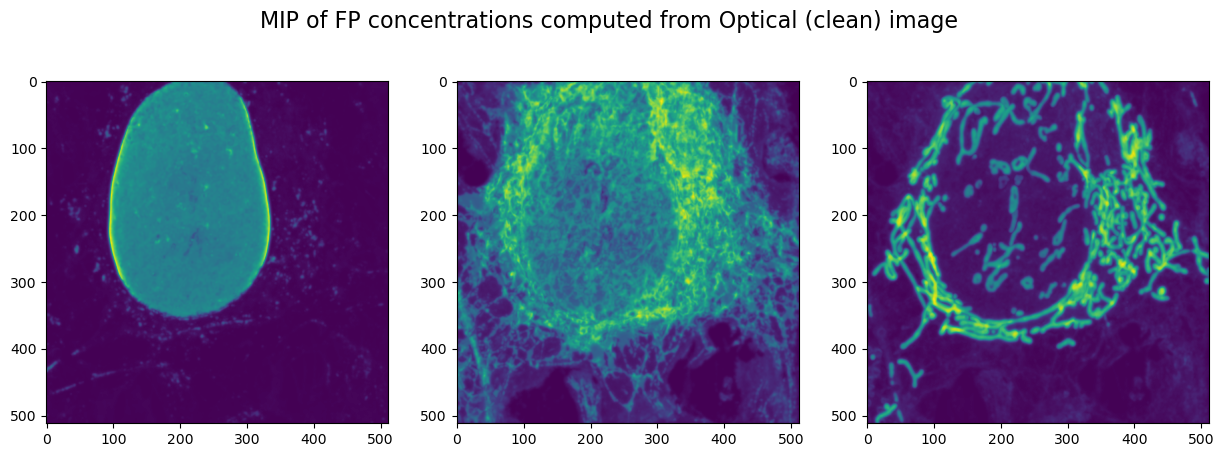

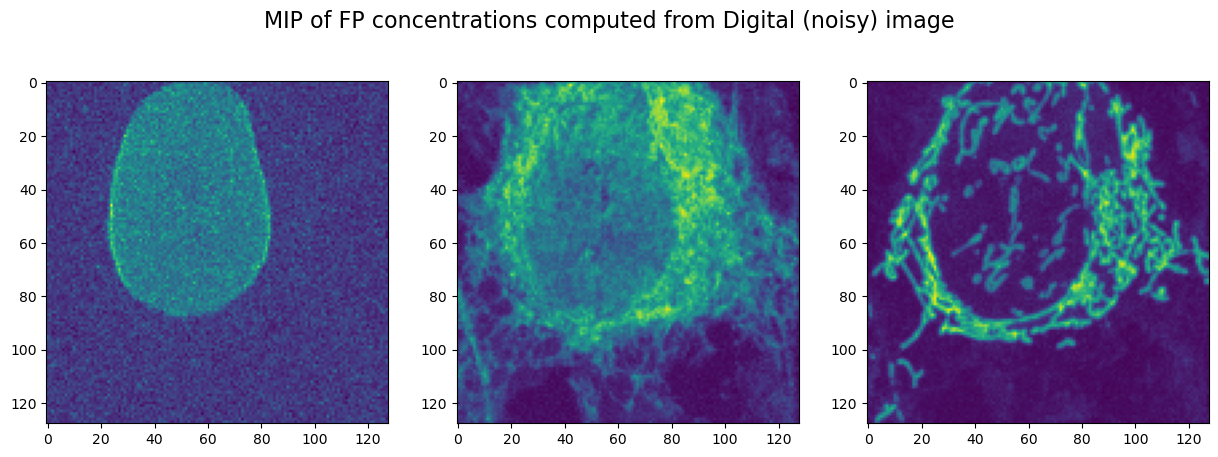

In [46]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("MIP of FP concentrations computed from Optical (clean) image", fontsize=16)
if load_mip:
    ax[0].imshow(fp_conc_opt_img[0, :, :])
    ax[1].imshow(fp_conc_opt_img[1, :, :])
    ax[2].imshow(fp_conc_opt_img[2, :, :])
else:
    ax[0].imshow(fp_conc_opt_img.max(axis=1)[0, :, :])
    ax[1].imshow(fp_conc_opt_img.max(axis=1)[1, :, :])
    ax[2].imshow(fp_conc_opt_img.max(axis=1)[2, :, :])


fig, ax = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("MIP of FP concentrations computed from Digital (noisy) image", fontsize=16)
if load_mip:
    ax[0].imshow(fp_conc_digital_img[0, :, :])
    ax[1].imshow(fp_conc_digital_img[1, :, :])
    ax[2].imshow(fp_conc_digital_img[2, :, :])
else:
    ax[0].imshow(fp_conc_digital_img.max(axis=1)[0, :, :])
    ax[1].imshow(fp_conc_digital_img.max(axis=1)[1, :, :])
    ax[2].imshow(fp_conc_digital_img.max(axis=1)[2, :, :])

### 4. Evaluation

Compute error with respect to ground truth.

The ground truth is a `(F, Z, Y, X)` array which reports the number of fluorophores per pixel.

In [47]:
# Load GT
gt_img = tiff.imread(os.path.join(DATA_DIR, "ground_truth_img.tif"))

In [48]:
# Downscale GT to match the size of digital image
import xarray as xr 

def coarsen_img(
    img: np.ndarray, 
    downscaling_factor: int
) -> np.ndarray:
    
    assert isinstance(downscaling_factor, int), "Downscaling factor must be a single int!"
    
    if len(img.shape) == 4:
        dimnames = ["c", "z", "y", "x"]
    elif len(img.shape) == 3:
        dimnames = ["c", "y", "x"]
    
    img_array = xr.DataArray(img, dims=dimnames)
    coarsened_dims = {dim: downscaling_factor for dim in img_array.dims[1:]}
    return img_array.coarsen(coarsened_dims).sum().data
    

In [49]:
try:
    downscaling = int(sim_metadata["downscale"])
except:
    downscaling = 2
gt_img_downsc = coarsen_img(gt_img, downscaling)

In [ ]:
# TODO: print some spectral bands

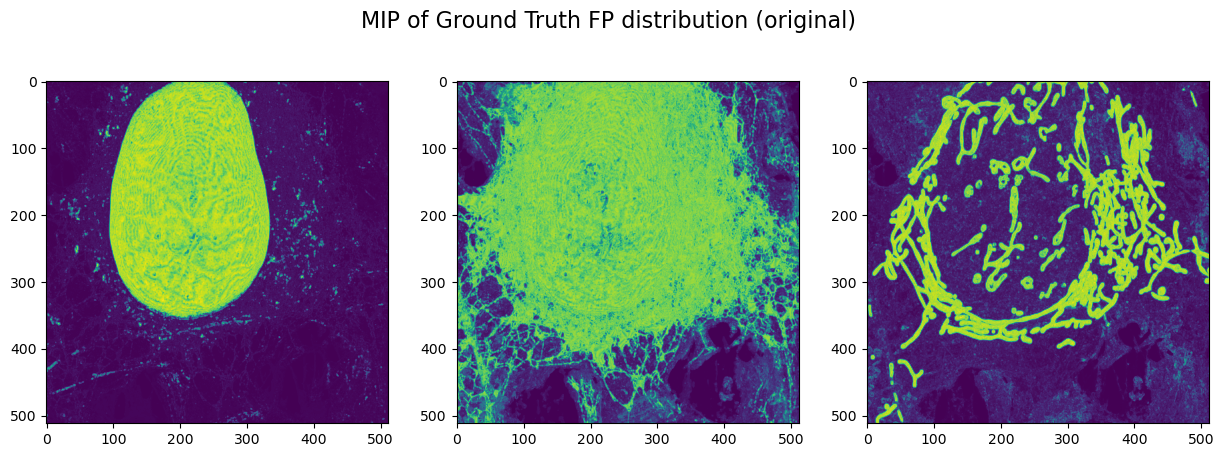

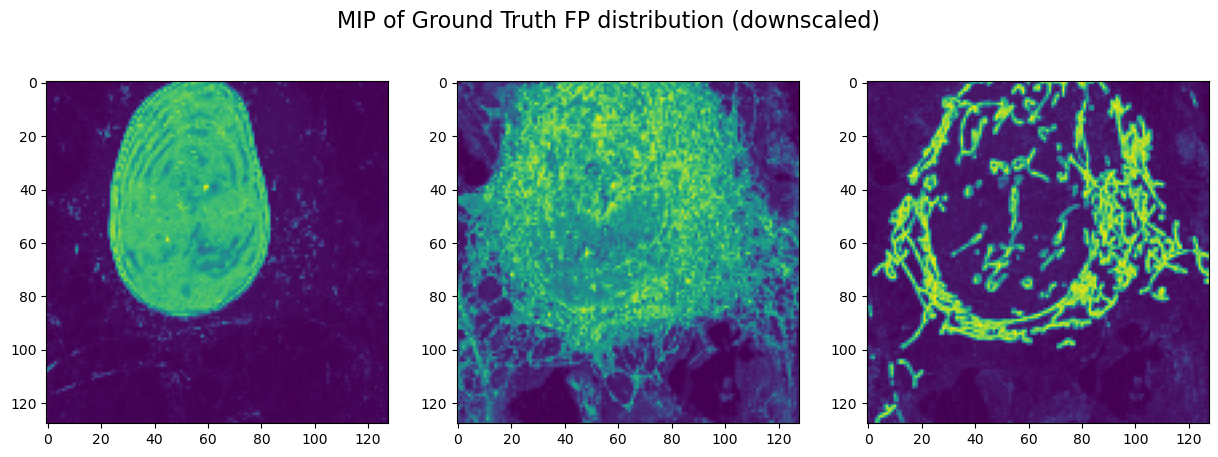

In [50]:
# Visualize GT
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("MIP of Ground Truth FP distribution (original)", fontsize=16)
ax[0].imshow(gt_img.max(axis=1)[0, :, :])
ax[1].imshow(gt_img.max(axis=1)[1, :, :])
ax[2].imshow(gt_img.max(axis=1)[2, :, :])


fig, ax = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("MIP of Ground Truth FP distribution (downscaled)", fontsize=16)
ax[0].imshow(gt_img_downsc.max(axis=1)[0, :, :])
ax[1].imshow(gt_img_downsc.max(axis=1)[1, :, :])
ax[2].imshow(gt_img_downsc.max(axis=1)[2, :, :])

Compare fluorophore distribution in the GT and concentration distribution obtained as solution of Linear System

(0.0, 11000000.0)

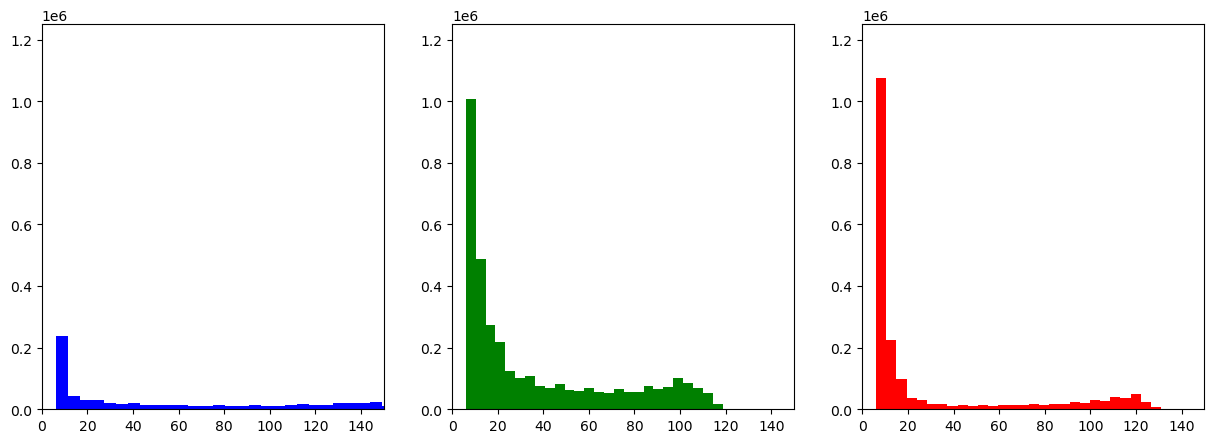

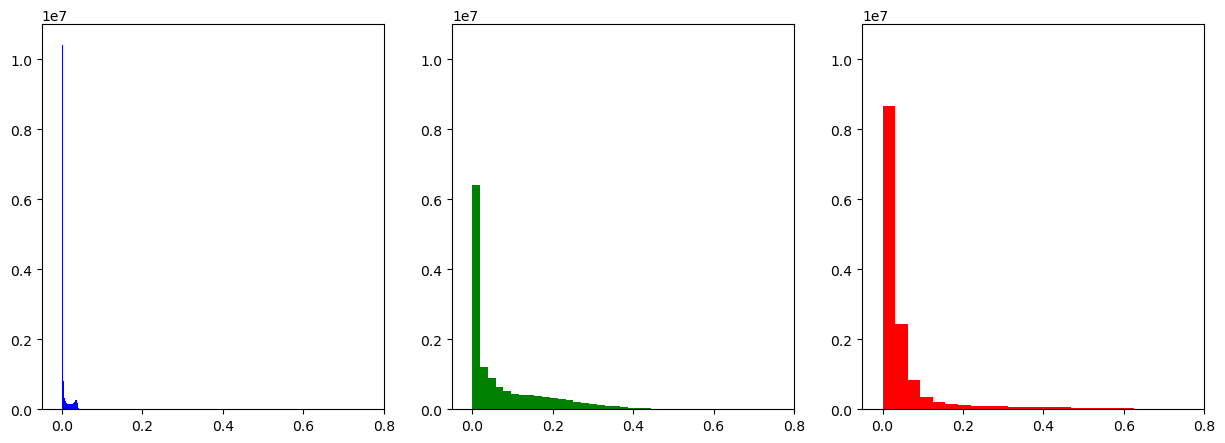

In [51]:
# Fluorophore distribution in GT
_, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].hist(gt_img[0, ...][gt_img[0, ...] > 5].flatten(), bins=30, color="blue")
ax[1].hist(gt_img[1, ...][gt_img[1, ...] > 5].flatten(), bins=30, color="green")
ax[2].hist(gt_img[2, ...][gt_img[2, ...] > 5].flatten(), bins=30, color="red")
# Put same limits for all histograms
ax[0].set_xlim([0, 150])
ax[1].set_xlim([0, 150])
ax[2].set_xlim([0, 150])
ax[0].set_ylim([0, 1.25e6])
ax[1].set_ylim([0, 1.25e6])
ax[2].set_ylim([0, 1.25e6])

# FP concentration distribution in unmixed images
_, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].hist(fp_conc_opt_img[0, ...].flatten(), bins=30, color="blue")
ax[1].hist(fp_conc_opt_img[1, ...].flatten(), bins=30, color="green")
ax[2].hist(fp_conc_opt_img[2, ...].flatten(), bins=30, color="red")
# Put same limits for all histograms
ax[0].set_xlim([-.05, .8])
ax[1].set_xlim([-.05, .8])
ax[2].set_xlim([-.05, .8])
ax[0].set_ylim([0, 1.1e7])
ax[1].set_ylim([0, 1.1e7])
ax[2].set_ylim([0, 1.1e7])

In [52]:
def channel_wise_normalization(img):
    ndims = tuple(range(len(img.shape)))
    channel_min = img.min(axis=ndims[1:], keepdims=True) 
    channel_max = img.max(axis=ndims[1:], keepdims=True)
    return (img - channel_min) / (channel_max - channel_min)

In [53]:
norm_fp_conc_opt_img = channel_wise_normalization(fp_conc_opt_img)
norm_fp_conc_digital_img = channel_wise_normalization(fp_conc_digital_img)
norm_gt_img = channel_wise_normalization(gt_img)
norm_gt_img_downsc = channel_wise_normalization(gt_img_downsc)

(array([8.677738e+06, 2.424019e+06, 8.375610e+05, 3.500130e+05,
        2.123190e+05, 1.550280e+05, 1.229980e+05, 1.037580e+05,
        9.013200e+04, 8.091400e+04, 7.294600e+04, 6.825800e+04,
        6.335000e+04, 5.838800e+04, 5.272900e+04, 4.751400e+04,
        4.331100e+04, 3.864500e+04, 3.427300e+04, 2.779000e+04,
        2.092100e+04, 1.535600e+04, 1.113400e+04, 8.245000e+03,
        5.910000e+03, 3.823000e+03, 2.452000e+03, 1.299000e+03,
        5.350000e+02, 1.290000e+02]),
 array([0.        , 0.03333333, 0.06666667, 0.1       , 0.13333333,
        0.16666667, 0.2       , 0.23333333, 0.26666667, 0.3       ,
        0.33333333, 0.36666667, 0.4       , 0.43333333, 0.46666667,
        0.5       , 0.53333333, 0.56666667, 0.6       , 0.63333333,
        0.66666667, 0.7       , 0.73333333, 0.76666667, 0.8       ,
        0.83333333, 0.86666667, 0.9       , 0.93333333, 0.96666667,
        1.        ]),
 <BarContainer object of 30 artists>)

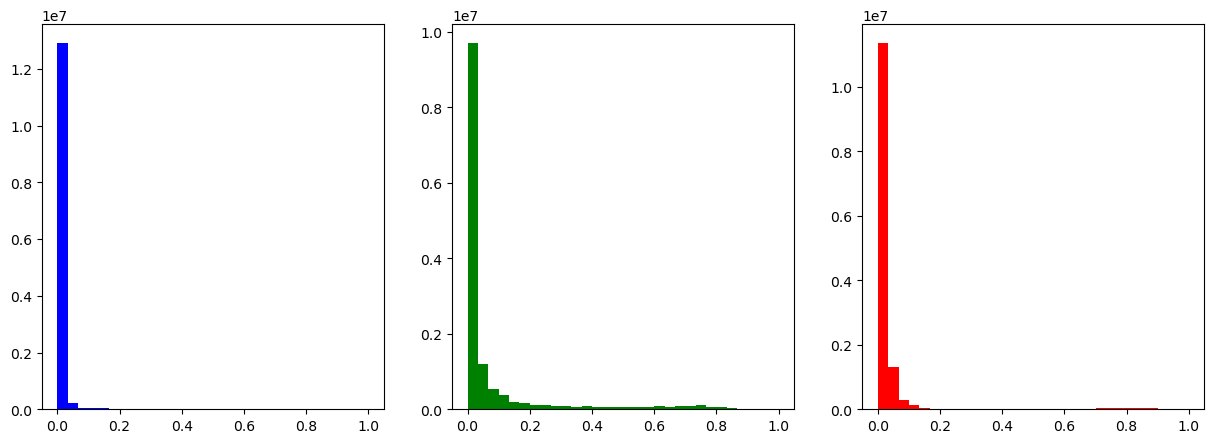

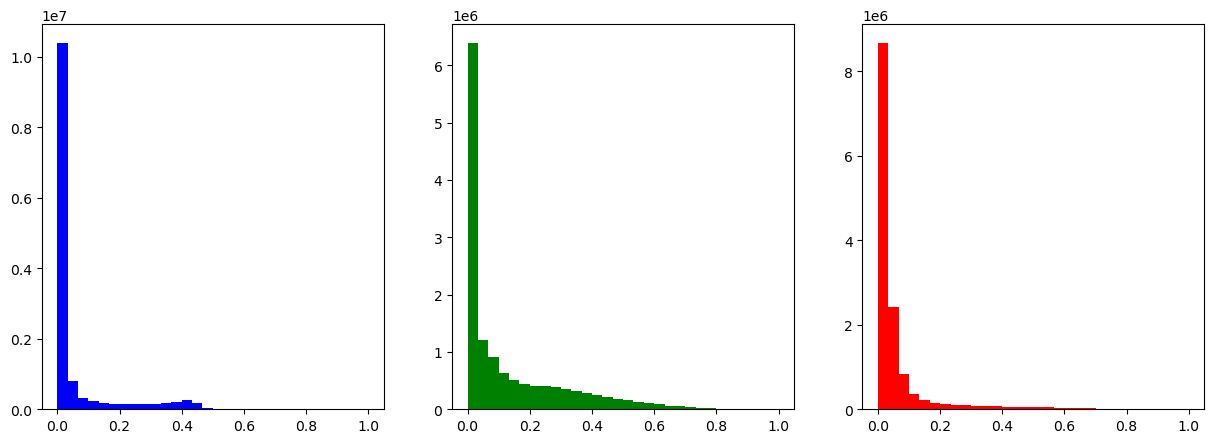

In [54]:
# Fluorophore distribution in GT
_, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].hist(norm_gt_img[0, ...].flatten(), bins=30, color="blue")
ax[1].hist(norm_gt_img[1, ...].flatten(), bins=30, color="green")
ax[2].hist(norm_gt_img[2, ...].flatten(), bins=30, color="red")
# Put same limits for all histograms
# ax[0].set_xlim([0, 150])
# ax[1].set_xlim([0, 150])
# ax[2].set_xlim([0, 150])
# ax[0].set_ylim([0, 1.25e6])
# ax[1].set_ylim([0, 1.25e6])
# ax[2].set_ylim([0, 1.25e6])

# FP concentration distribution in unmixed images
_, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].hist(norm_fp_conc_opt_img[0, ...].flatten(), bins=30, color="blue")
ax[1].hist(norm_fp_conc_opt_img[1, ...].flatten(), bins=30, color="green")
ax[2].hist(norm_fp_conc_opt_img[2, ...].flatten(), bins=30, color="red")
# Put same limits for all histograms
# ax[0].set_xlim([-.05, .8])
# ax[1].set_xlim([-.05, .8])
# ax[2].set_xlim([-.05, .8])
# ax[0].set_ylim([0, 1.1e7])
# ax[1].set_ylim([0, 1.1e7])
# ax[2].set_ylim([0, 1.1e7])

We appy min-max normalization to both ground truth (#FP/pixel) and the LS result (FP concentratio/pixel) in order to get comparable arrays

In [55]:
def channel_wise_norm(arr: np.ndarray) -> np.ndarray:
    spatial_dims = tuple(range(len(arr.shape))[1:])
    pixel_mins = arr.min(axis=spatial_dims, keepdims=True)
    pixel_maxs = arr.max(axis=spatial_dims, keepdims=True)
    
    return (arr - pixel_mins) / (pixel_maxs - pixel_mins + np.finfo(float).eps)

def pixel_wise_norm(arr: np.ndarray) -> np.ndarray:
    pixel_mins = arr.min(axis=0, keepdims=True)
    pixel_maxs = arr.max(axis=0, keepdims=True)
    
    return (arr - pixel_mins) / (pixel_maxs - pixel_mins + np.finfo(float).eps)

In [56]:
norm_fp_conc_opt_img = channel_wise_norm(fp_conc_opt_img)
norm_fp_conc_digital_img = channel_wise_norm(fp_conc_digital_img)
norm_gt_img = channel_wise_norm(gt_img)
norm_gt_img_downsc = channel_wise_norm(gt_img_downsc)

Now, we compute and visualize the error:

In [57]:
def pixel_wise_mse(gt_img, unmixed_img):
    return (gt_img - unmixed_img)**2

Optical Image MSE: 1.22e-02, 2.00e-02, 6.17e-03


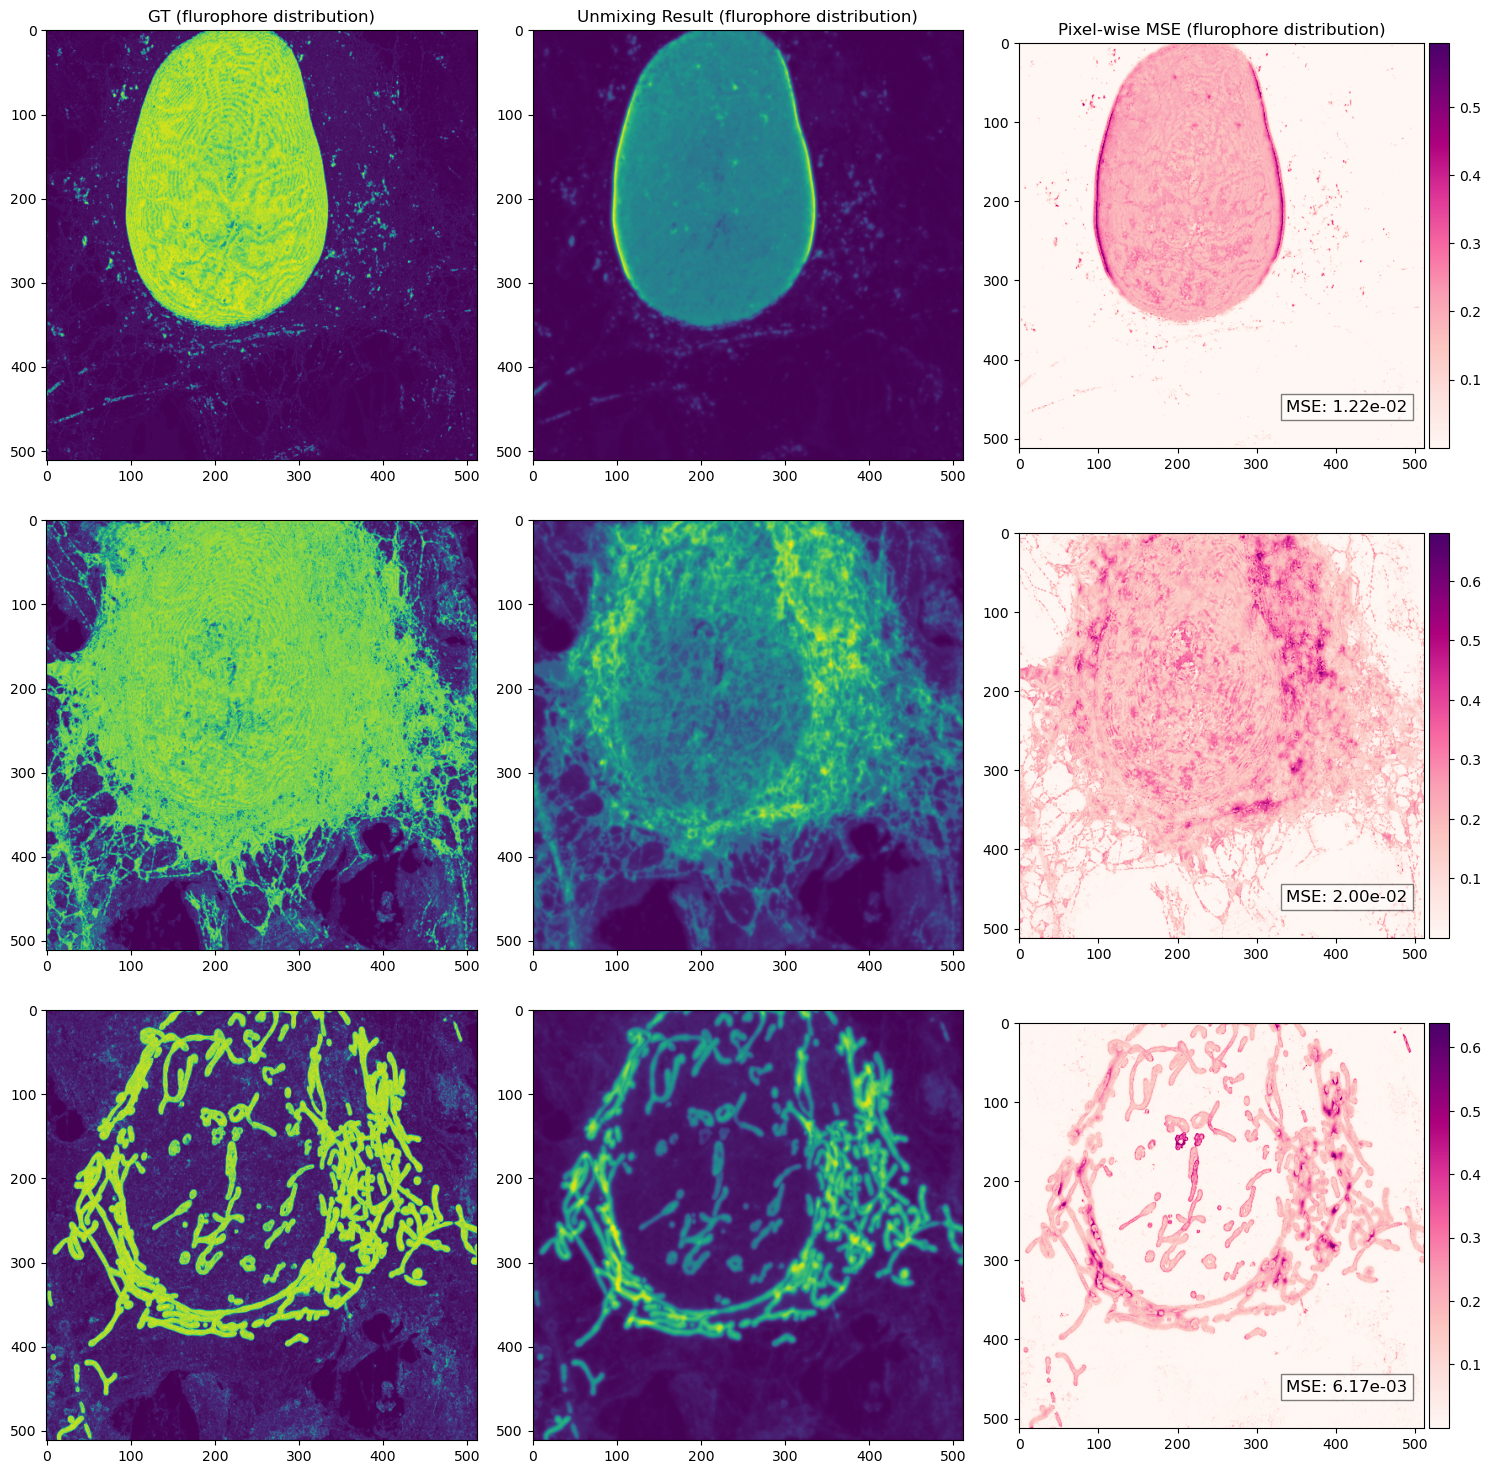

In [58]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(3, 3, figsize=(15, 15))
# fig.suptitle("Ground Truth FP distribution vs. Unmixed FP Concentrations (normalize in 0-1)", fontsize=16)

mse1 = pixel_wise_mse(norm_gt_img[0, ...], norm_fp_conc_opt_img[0, ...])
ax[0,0].set_title("GT (flurophore distribution)")
im0 = ax[0,0].imshow(norm_gt_img.max(axis=1)[0, :, :])
ax[0,1].set_title("Unmixing Result (flurophore distribution)")
im1 = ax[0,1].imshow(norm_fp_conc_opt_img.max(axis=1)[0, :, :])
ax[0,2].set_title("Pixel-wise MSE (flurophore distribution)")
im2 = ax[0,2].imshow(mse1.max(axis=0), cmap="RdPu")
divider = make_axes_locatable(ax[0,2])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im2, cax=cax)
ax[0,2].text(
    0.66, 0.1, f'MSE: {mse1.mean():.2e}', transform=ax[0,2].transAxes,
    fontsize=12, verticalalignment='center', bbox=dict(facecolor='white', alpha=0.5)
)

mse2 = pixel_wise_mse(norm_gt_img[1, ...], norm_fp_conc_opt_img[1, ...])
im3 = ax[1,0].imshow(norm_gt_img.max(axis=1)[1, :, :])
im4 = ax[1,1].imshow(norm_fp_conc_opt_img.max(axis=1)[1, :, :])
im5 = ax[1,2].imshow(mse2.max(axis=0), cmap="RdPu")
divider = make_axes_locatable(ax[1,2])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im5, cax=cax)
ax[1,2].text(
    0.66, 0.1, f'MSE: {mse2.mean():.2e}', transform=ax[1,2].transAxes,
    fontsize=12, verticalalignment='center', bbox=dict(facecolor='white', alpha=0.5)
)

mse3 = pixel_wise_mse(norm_gt_img[2, ...], norm_fp_conc_opt_img[2, ...])
im6 = ax[2,0].imshow(norm_gt_img.max(axis=1)[2, :, :])
im7 = ax[2,1].imshow(norm_fp_conc_opt_img.max(axis=1)[2, :, :])
im8 = ax[2,2].imshow(mse3.max(axis=0), cmap="RdPu")
divider = make_axes_locatable(ax[2,2])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im8, cax=cax)
ax[2,2].text(
    0.66, 0.1, f'MSE: {mse3.mean():.2e}', transform=ax[2,2].transAxes,
    fontsize=12, verticalalignment='center', bbox=dict(facecolor='white', alpha=0.5)
)

plt.tight_layout()

# Quantititive results
print(f"Optical Image MSE: {mse1.mean():.2e}, {mse2.mean():.2e}, {mse3.mean():.2e}")

Digital Image MSE: 1.09e-01, 2.38e-02, 9.06e-03


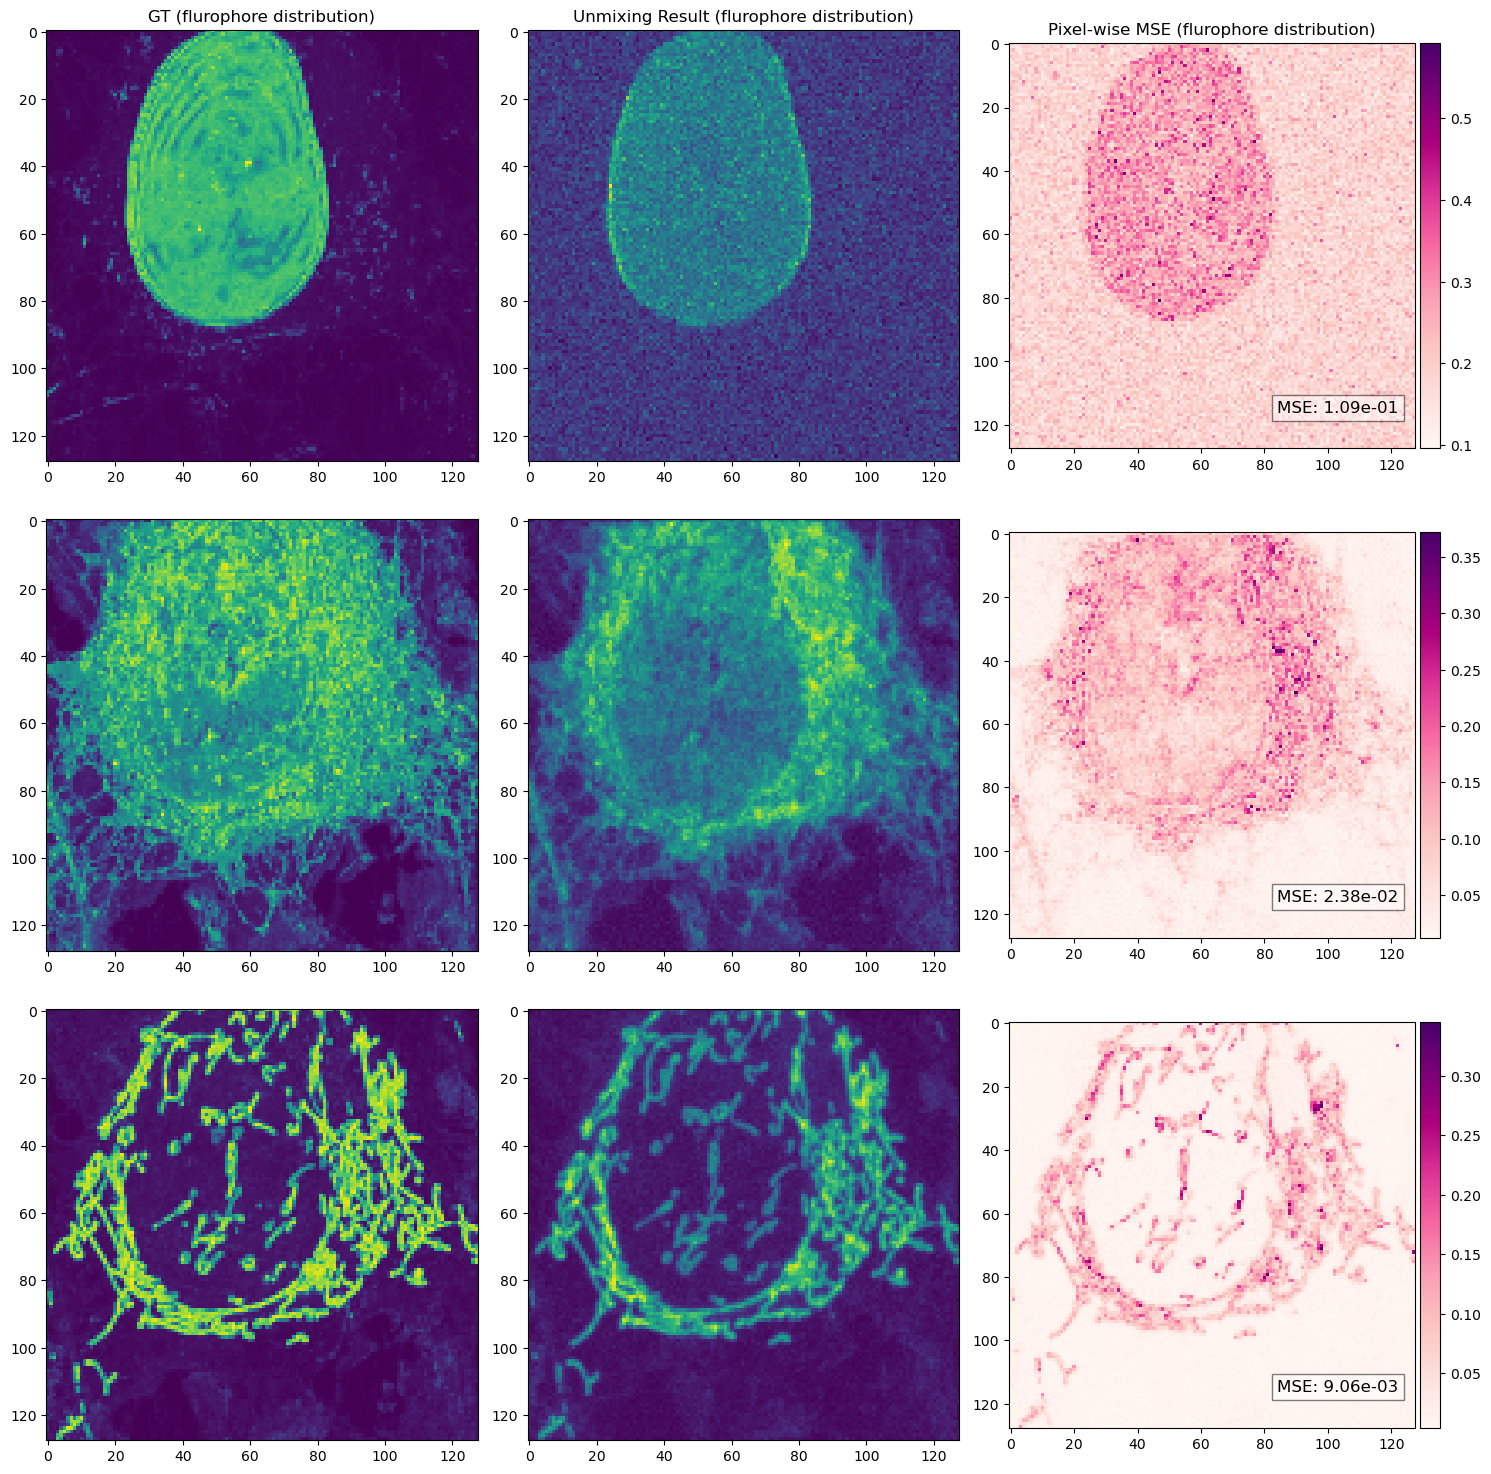

In [59]:
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
# fig.suptitle("Ground Truth FP distribution vs. Unmixed FP Concentrations (normalize in 0-1)", fontsize=16)

mse1 = pixel_wise_mse(norm_gt_img_downsc[0, ...], norm_fp_conc_digital_img[0, ...])
ax[0,0].set_title("GT (flurophore distribution)")
im0 = ax[0,0].imshow(norm_gt_img_downsc.max(axis=1)[0, :, :])
ax[0,1].set_title("Unmixing Result (flurophore distribution)")
im1 = ax[0,1].imshow(norm_fp_conc_digital_img.max(axis=1)[0, :, :])
ax[0,2].set_title("Pixel-wise MSE (flurophore distribution)")
im2 = ax[0,2].imshow(mse1.max(axis=0), cmap="RdPu")
divider = make_axes_locatable(ax[0,2])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im2, cax=cax)
ax[0,2].text(
    0.66, 0.1, f'MSE: {mse1.mean():.2e}', transform=ax[0,2].transAxes,
    fontsize=12, verticalalignment='center', bbox=dict(facecolor='white', alpha=0.5)
)

mse2 = pixel_wise_mse(norm_gt_img_downsc[1, ...], norm_fp_conc_digital_img[1, ...])
im3 = ax[1,0].imshow(norm_gt_img_downsc.max(axis=1)[1, :, :])
im4 = ax[1,1].imshow(norm_fp_conc_digital_img.max(axis=1)[1, :, :])
im5 = ax[1,2].imshow(mse2.max(axis=0), cmap="RdPu")
divider = make_axes_locatable(ax[1,2])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im5, cax=cax)
ax[1,2].text(
    0.66, 0.1, f'MSE: {mse2.mean():.2e}', transform=ax[1,2].transAxes,
    fontsize=12, verticalalignment='center', bbox=dict(facecolor='white', alpha=0.5)
)

mse3 = pixel_wise_mse(norm_gt_img_downsc[2, ...], norm_fp_conc_digital_img[2, ...])
im6 = ax[2,0].imshow(norm_gt_img_downsc.max(axis=1)[2, :, :])
im7 = ax[2,1].imshow(norm_fp_conc_digital_img.max(axis=1)[2, :, :])
im8 = ax[2,2].imshow(mse3.max(axis=0), cmap="RdPu")
divider = make_axes_locatable(ax[2,2])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im8, cax=cax)
ax[2,2].text(
    0.66, 0.1, f'MSE: {mse3.mean():.2e}', transform=ax[2,2].transAxes,
    fontsize=12, verticalalignment='center', bbox=dict(facecolor='white', alpha=0.5)
)

plt.tight_layout()

# Quantititive results
print(f"Digital Image MSE: {mse1.mean():.2e}, {mse2.mean():.2e}, {mse3.mean():.2e}")